Global fake rate: 0.08888013653669424


Info in <TCanvas::Print>: pdf file AnalysisPlot.pdf has been created
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf


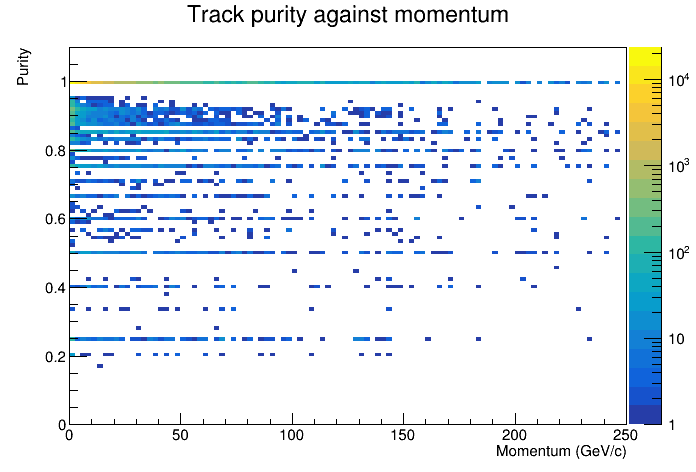

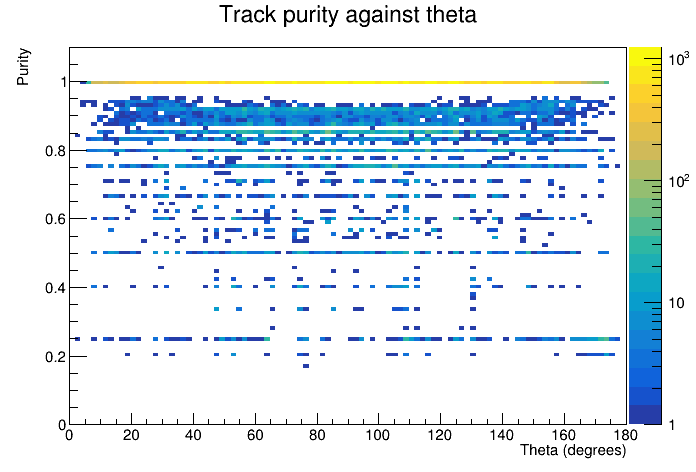

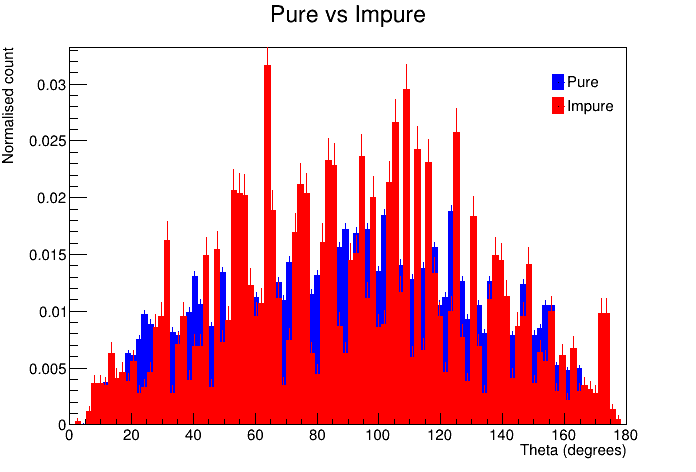

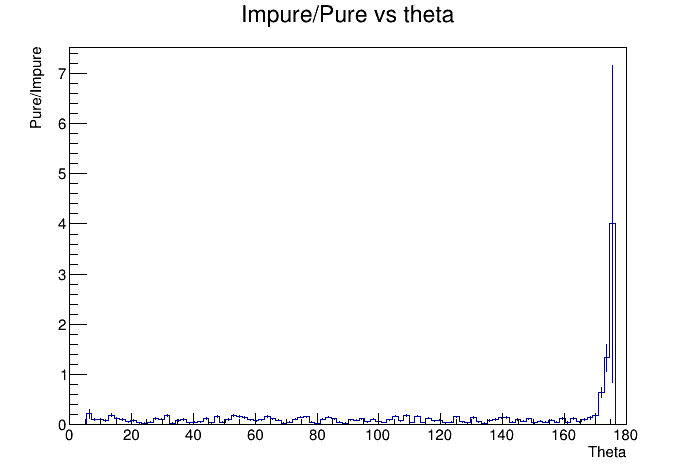

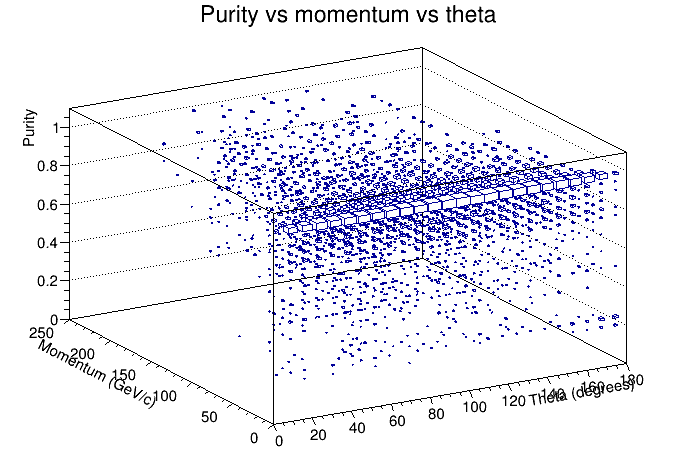

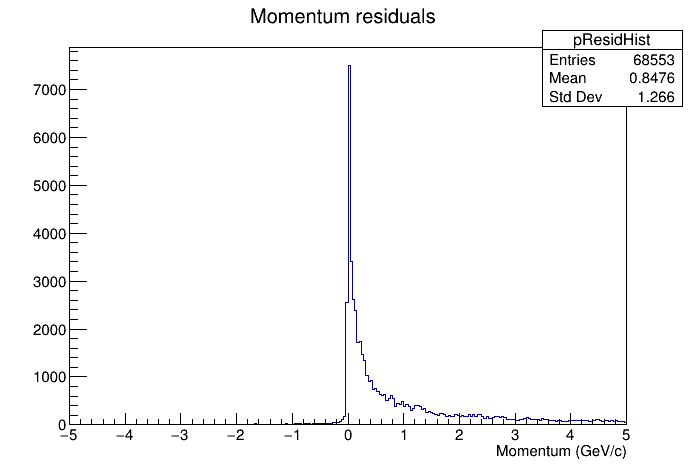

In [14]:
import ROOT
import os

# Written in Python 3. Requires a version of root to be compiled with the Python 3 option.
# Might work with Python2, though may require some modification.


inputFileName = "Merged.root"
#inputFileName = "ReducedSupport.root"
#inputFileName = "Thin.root"
#inputFileName = "Cut.root"
#inputFileName = "HeavySilicon.root"

# The output file will do weird things unless all the cells are run consecutivly
outputFileName = "AnalysisPlot.pdf"
#outputFileName = "10MicroMeterSensitiveAnalysisPlot.pdf"

momentumHistMax = 250

myFile = ROOT.TFile(inputFileName)
myChainTrack = myFile.Get("MyTrackChecker").Get("checktree")
myChainPurity = myFile.Get("MyClicEfficiencyCalculator").Get("puritytree")
# Works since same events and thus same total number of events
entryNum = myChainTrack.GetEntriesFast()

purityVSp = ROOT.TH2D("purityVSp", "Track purity against momentum"
                      , 100, 0, momentumHistMax, 100, 0, 1.1)
purityVSp.GetXaxis().SetTitle("Momentum (GeV/c)")
purityVSp.GetYaxis().SetTitle("Purity")

purityVStheta = ROOT.TH2D("purityVStheta", "Track purity against theta"
                          , 100, 0, 180, 100, 0, 1.1)
purityVStheta.GetXaxis().SetTitle("Theta (degrees)")
purityVStheta.GetYaxis().SetTitle("Purity")

# For pure VS impure against theta
pureVStheta = ROOT.TH1D("pureVStheta", "FOO", 100, 0, 180)
impureVStheta = ROOT.TH1D("impureVStheta", "", 100, 0, 180)

purityVSp.SetStats(False)
purityVStheta.SetStats(False)

purityVSpVStheta = ROOT.TH3D("purityVSpVStheta" ,"Purity vs momentum vs theta"
                             , 25,0,180, 25,0,momentumHistMax, 25,0,1.1)
purityVSpVStheta.GetXaxis().SetTitle("Theta (degrees)")
purityVSpVStheta.GetYaxis().SetTitle("Momentum (GeV/c)")
purityVSpVStheta.GetZaxis().SetTitle("Purity")

pResidHist = ROOT.TH1D("pResidHist", "Momentum residuals", 250, -5, 5)
pResidHist.GetXaxis().SetTitle("Momentum (GeV/c)")

fakeNum = 0
totalNum = 0
for jEnt in range(entryNum):
    # I'm not really sure what this does, but I'm sure its important
    iEntTrack = myChainTrack.LoadTree(jEnt)
    iEntPurity = myChainTrack.LoadTree(jEnt)
    if iEntTrack < 0 and iEntPurity < 0:
        break
    
    nbTrack = myChainTrack.GetEntry(jEnt)
    nbPurity = myChainPurity.GetEntry(jEnt)
    if nbTrack <= 0 and nbPurity <=0:
        continue
    
    truePs = myChainTrack.truePt
    trueThetas = myChainTrack.trueTheta
    purities = myChainPurity.trk_purity
    recoPs = myChainTrack.recoP
    
    for trueP, purity, trueTheta, recoP in zip(truePs, purities, trueThetas, recoPs):
        totalNum +=1
        purityVSp.Fill(trueP, purity)
        purityVStheta.Fill(trueTheta, purity)
        purityVSpVStheta.Fill(trueTheta, trueP, purity)
        pResidHist.Fill(recoP - trueP)
        
        # Selection criteria used by exisitng CLICPeformance code
        if purity >= 0.9:
            pureVStheta.Fill(trueTheta)
        
        else:
            impureVStheta.Fill(trueTheta)
            fakeNum += 1


            
            

print(f"Global fake rate: {fakeNum/totalNum}")


impureDivPureVStheta = impureVStheta.Clone()
impureDivPureVStheta.Sumw2()
impureDivPureVStheta.Divide(pureVStheta)
impureDivPureVStheta.SetStats(False)
impureDivPureVStheta.SetTitle("Impure/Pure vs theta")
impureDivPureVStheta.GetXaxis().SetTitle("Theta")
impureDivPureVStheta.GetYaxis().SetTitle("Pure/Impure")

pureVStheta.SetFillColor(ROOT.kBlue)
pureVStheta.SetLineColor(ROOT.kBlue)
pureVStheta.Scale(1/pureVStheta.Integral())
impureVStheta.SetFillColor(ROOT.kRed)
impureVStheta.SetLineColor(ROOT.kRed)
impureVStheta.Scale(1/impureVStheta.Integral())

pureImpureTheta = ROOT.THStack()
pureImpureTheta.Add(pureVStheta)
pureImpureTheta.Add(impureVStheta)




# Removes existing file
if fullRun: 
    try:
        os.remove(outputFileName)
    except OSError:
        pass

canvas = ROOT.TCanvas()
canvas.SetLogz(1)
purityVSp.Draw("COLZ")
canvas.Draw()
canvas.Print(outputFileName + "[")
canvas.Print(outputFileName)


canvas1 = ROOT.TCanvas()
canvas1.SetLogz(1)
purityVStheta.Draw("COLZ")
canvas1.Draw()
canvas1.Print(outputFileName)


canvas2 = ROOT.TCanvas()
pureImpureTheta.Draw("nostack, h")
pureVStheta.Scale(1/pureVStheta.Integral())
legend = ROOT.TLegend(0.79, 0.75, 0.89, 0.85)
legend.AddEntry(pureVStheta, "Pure")
legend.AddEntry(impureVStheta, "Impure")
legend.SetLineWidth(0)
legend.Draw()
# Can only be set after drawing for stacked histograms
pureImpureTheta.GetXaxis().SetTitle("Theta (degrees)")
pureImpureTheta.GetYaxis().SetTitle("Normalised count")
pureImpureTheta.SetTitle("Pure vs Impure")
#pureImpureTheta.SetStats(False)
canvas2.Draw()
canvas2.Print(outputFileName)

canvas3 = ROOT.TCanvas()
impureDivPureVStheta.Draw("eh")
canvas3.Draw()
canvas3.Print(outputFileName)

canvas4 = ROOT.TCanvas()
purityVSpVStheta.Draw("BOX")
canvas4.Draw()
canvas4.Print(outputFileName)

canvas5 = ROOT.TCanvas()
pResidHist.Draw()
canvas5.Draw()
canvas5.Print(outputFileName)


Global Efficiency: 0.9468767515725229


Warning in <TFile::Append>: Replacing existing TH1: recoVStheta (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: recoVSpt (Potential memory leak).
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf


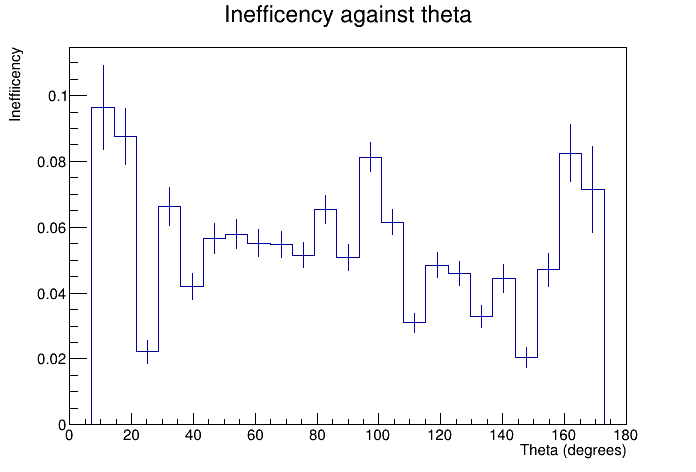

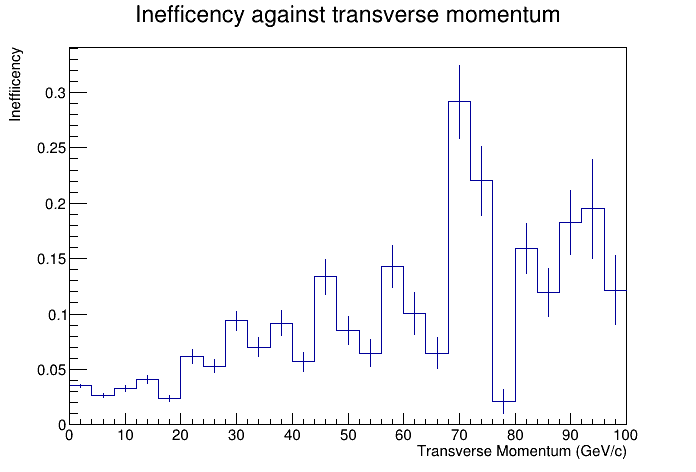

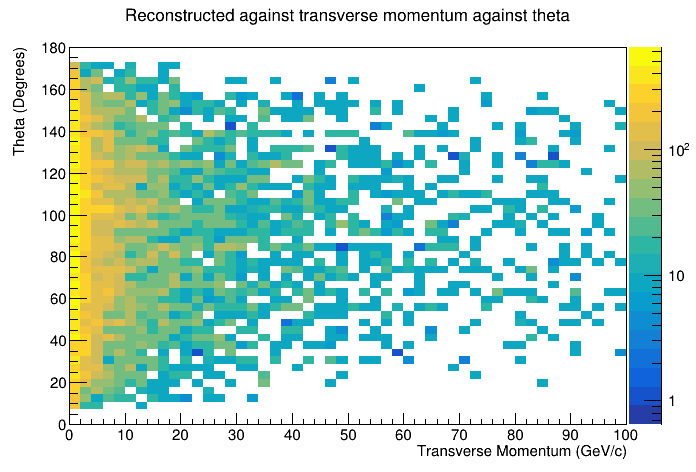

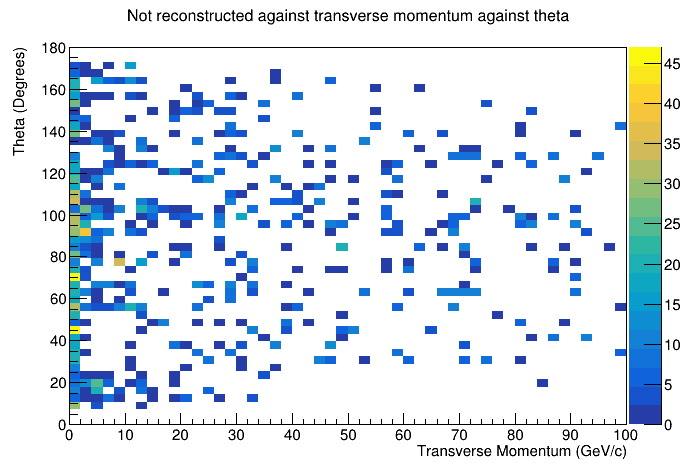

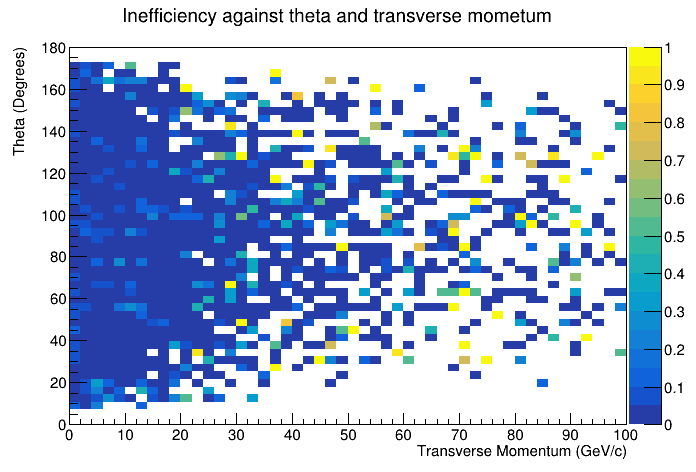

In [15]:
# Efficiency Plots

ptHistMax = 100

myChainSimpEff = myFile.Get("MyClicEfficiencyCalculator").Get("simplifiedEfficiencyTree")
entryNumSimpEff = myChainSimpEff.GetEntriesFast()

recoVStheta = ROOT.TH1D("recoVStheta", "Reconstructed against theta", 25, 0, 180)
notRecoVStheta = ROOT.TH1D("recoVStheta", "Not reconstructed against theta", 25, 0, 180)

recoVSpt = ROOT.TH1D("recoVSpt", "Reconstructed against transverse momentum", 25, 0, ptHistMax)
notRecoVSpt = ROOT.TH1D("recoVSpt", "Not reconstructed against transverse momentum", 25, 0, ptHistMax)

recoVSptVStheta = ROOT.TH2D("recoVSptVStheta", "Reconstructed against transverse momentum against theta",
                            50,0,ptHistMax, 50,0,180)
notRecoVSptVStheta = ROOT.TH2D("notRecoVSptVStheta", "Not reconstructed against transverse momentum against theta",
                            50,0,ptHistMax, 50,0,180)

numReco = 0

# Requires seperate iteration as simple efficiency tree stores particle information
# sequentually and not by event
for jEnt in range(entryNumSimpEff):
    # Slightly cargo culty
    iEnt = myChainSimpEff.LoadTree(jEnt)
    if iEnt < 0:
        break
        
    nbSimpEff = myChainSimpEff.GetEntry(jEnt)
    if nbSimpEff <=0:
        continue
    
    theta = myChainSimpEff.m_theta
    pt = myChainSimpEff.m_pt
    reconstructed = myChainSimpEff.m_reconstructed
    
    if reconstructed:
        numReco += 1
        recoVStheta.Fill(theta)
        recoVSpt.Fill(pt)
        recoVSptVStheta.Fill(pt, theta)
        
    else:
        notRecoVStheta.Fill(theta)
        notRecoVSpt.Fill(pt)
        notRecoVSptVStheta.Fill(pt, theta)


print(f"Global Efficiency: {numReco/entryNumSimpEff}")
        
        
efficiencyVStheta = notRecoVStheta.Clone()
totalVStheta = notRecoVStheta.Clone()
totalVStheta.Add(recoVStheta, 1)
totalVStheta.Sumw2()
efficiencyVStheta.Divide(totalVStheta)
efficiencyVStheta.SetTitle("Inefficency against theta")
efficiencyVStheta.GetXaxis().SetTitle("Theta (degrees)")
efficiencyVStheta.GetYaxis().SetTitle("Ineffiicency")
efficiencyVStheta.SetStats(False)

efficiencyVSpt = notRecoVSpt.Clone()
totalVSpt = notRecoVSpt.Clone()
totalVSpt.Add(recoVSpt, 1)
totalVSpt.Sumw2()
efficiencyVSpt.Divide(totalVSpt)
efficiencyVSpt.SetTitle("Inefficency against transverse momentum")
efficiencyVSpt.GetXaxis().SetTitle("Transverse Momentum (GeV/c)")
efficiencyVSpt.GetYaxis().SetTitle("Ineffiicency")
efficiencyVSpt.SetStats(False)

efficiencyVSptVStheta = notRecoVSptVStheta.Clone()
totalVSptVStheta = notRecoVSptVStheta.Clone()
totalVSptVStheta.Add(recoVSptVStheta, 1)
efficiencyVSptVStheta.Divide(totalVSptVStheta)
# Hacky way to get it to display 0 for perfect efficiency rather then just blank
efficiencyVSptVStheta.Add(recoVSptVStheta, 0.0000000001)
efficiencyVSptVStheta.SetTitle("Inefficiency against theta and transverse mometum")


for histo in [recoVSptVStheta, notRecoVSptVStheta, efficiencyVSptVStheta]:
    histo.SetStats(False)
    histo.GetXaxis().SetTitle("Transverse Momentum (GeV/c)")
    histo.GetYaxis().SetTitle("Theta (Degrees)")


    
canvas = ROOT.TCanvas()
canvas.cd()
recoVStheta.Draw("eh")
#canvas.Draw()

canvas2 = ROOT.TCanvas()
canvas2.cd()
notRecoVStheta.Draw("eh")
#canvas2.Draw()

canvas3 = ROOT.TCanvas()
canvas3.cd()
efficiencyVStheta.Draw("eh")
canvas3.Draw()
canvas3.Print(outputFileName)

canvas4 = ROOT.TCanvas()
canvas4.cd()
efficiencyVSpt.Draw("eh")
canvas4.Draw()
canvas4.Print(outputFileName)

canvas5 = ROOT.TCanvas()
canvas5.cd()
canvas5.SetLogz(1)
recoVSptVStheta.Draw("COLZ")
canvas5.Draw()
canvas5.Print(outputFileName)

canvas6 = ROOT.TCanvas()
canvas6.cd()
notRecoVSptVStheta.Draw("COLZ")
canvas6.Draw()
canvas6.Print(outputFileName)

canvas6 = ROOT.TCanvas()
canvas6.cd()
efficiencyVSptVStheta.Draw("COLZ")
canvas6.Draw()
canvas6.Print(outputFileName)

Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file AnalysisPlot.pdf
Info in <TCanvas::Print>: pdf file AnalysisPlot.pdf has been closed


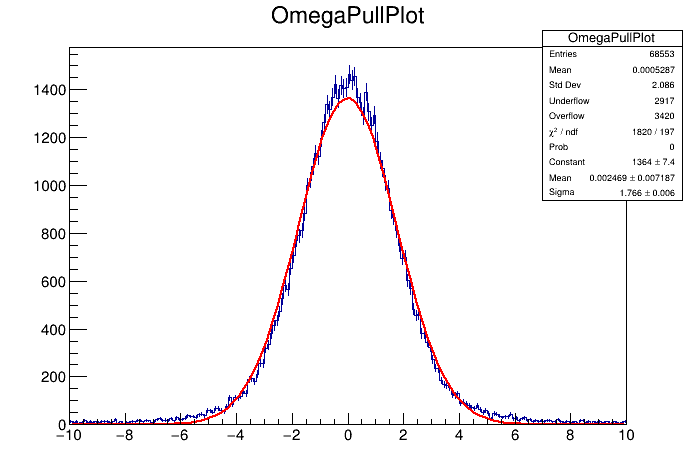

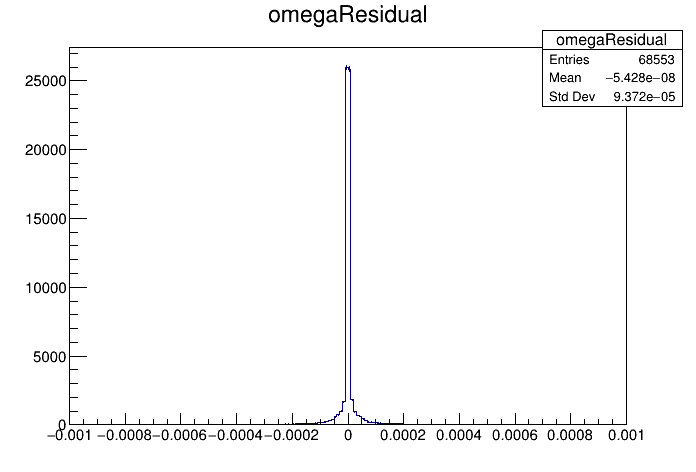

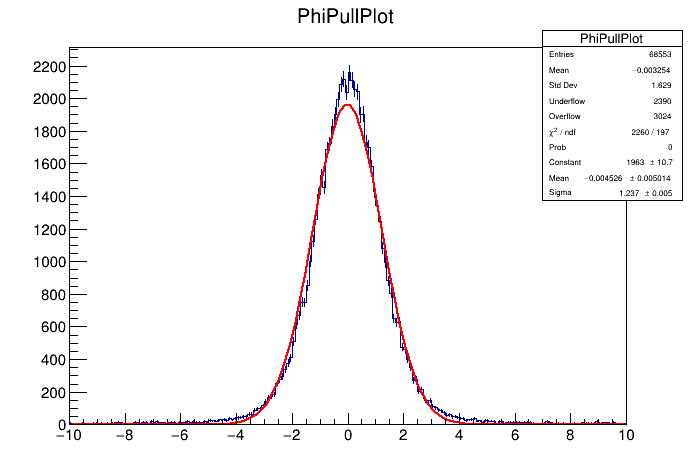

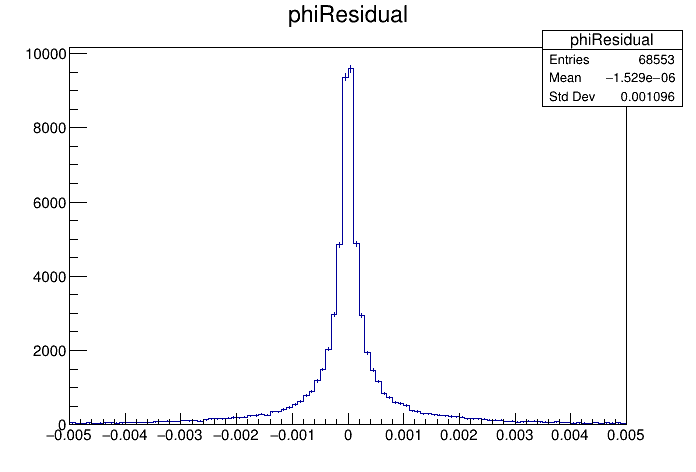

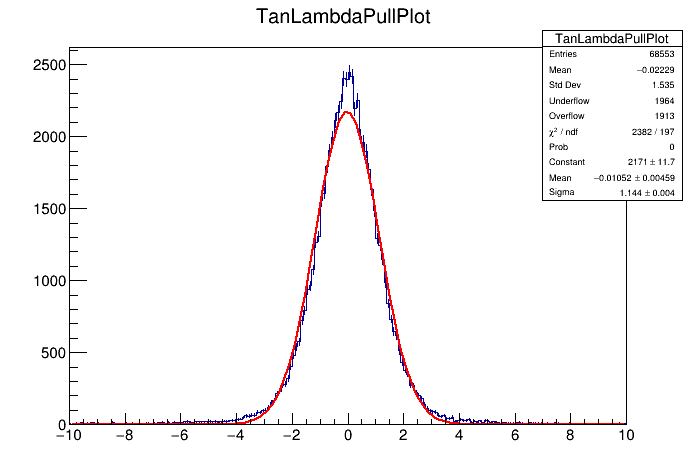

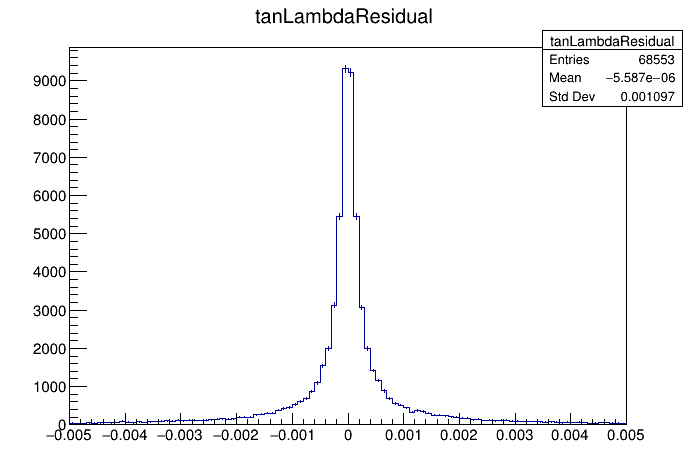

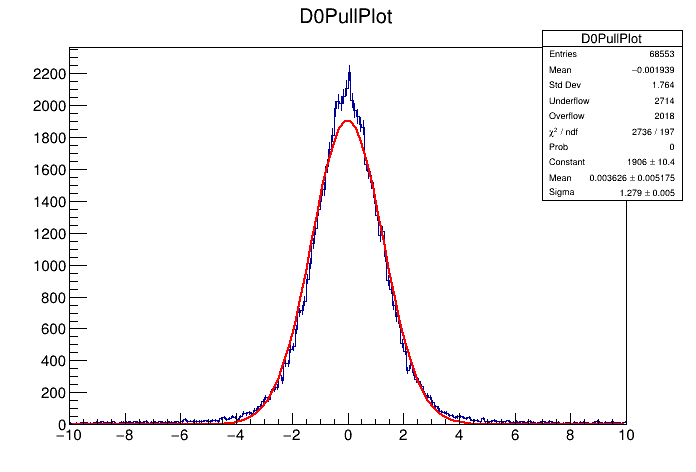

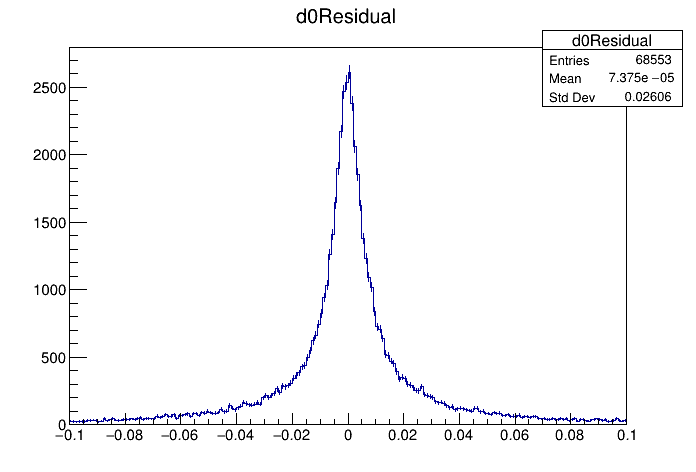

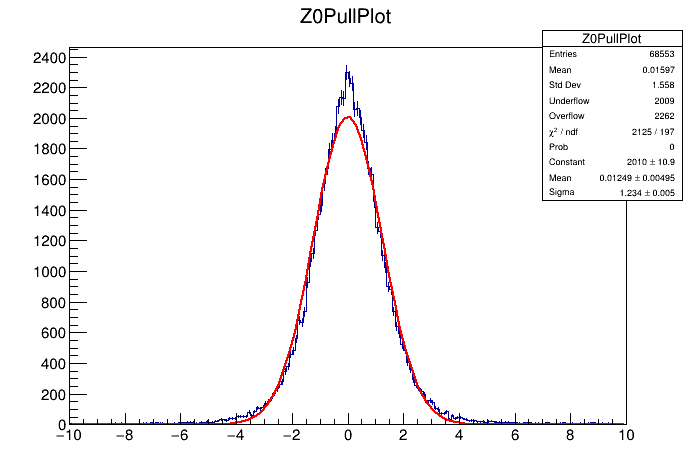

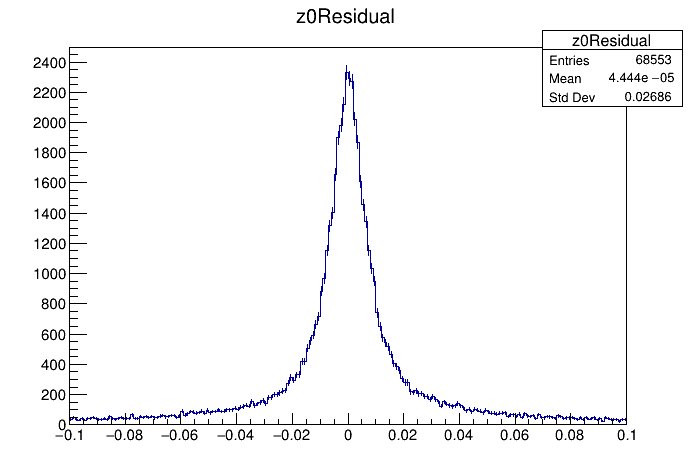

In [16]:
# Residual graphs

pullTitles = ["OmegaPullPlot", "PhiPullPlot", "TanLambdaPullPlot", "D0PullPlot", "Z0PullPlot"]
residTitles = ["omegaResidual", "phiResidual", "tanLambdaResidual", "d0Residual", "z0Residual"]

graphDirect = myFile.Get("MyTrackChecker")

baseCanvas = ROOT.TCanvas()

for pullTitle, residTitle in zip(pullTitles, residTitles):
    pullHist = graphDirect.Get(pullTitle)
    residHist = graphDirect.Get(residTitle)
    
    pullCanvas = ROOT.TCanvas()
    pullCanvas.cd()
    pullHist.Draw("eh")
    pullCanvas.Draw()
    pullCanvas.Print(outputFileName)
    
    residCanvas = ROOT.TCanvas()
    residCanvas.cd()
    residHist.Draw("eh")
    residCanvas.Draw()
    residCanvas.Print(outputFileName)

# If it exists
if canvas:
    canvas.Print(outputFileName + "]")

In [18]:
# This cell is used to probe the structure of root trees

import root_numpy

trkTree = myFile.Get("MyClicEfficiencyCalculator").Get("trktree")
trkArray = root_numpy.tree2array(trkTree)

for event in trkArray:
#     print(event[0])
    pass

# Log of changes to detector model and result

### Reduced vertex sensitive thickness from 50$\mu$m to 10$\mu$m
No significant change.

### Reduced vertex support silicon by 50%
No significant change observed.

### Reduced inner and outer tracker thickness to 50$\mu$
No significant change observed.

In [13]:
# This is purely book keeping. It resets the value after each full run.
fullRun = False